Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5587069771583775
Precision: 0.5322533149126764
Recall: 0.5587069771583775
F1 Score: 0.5405103941729145
Classification Report:
              precision    recall  f1-score   support

aburrimiento       0.83      1.00      0.91      1753
      alivio       0.51      0.57      0.54      1779
        amor       0.54      0.50      0.52      1696
   diversión       0.52      0.56      0.54      1776
       enojo       0.89      0.98      0.93      1677
  entusiasmo       0.59      0.77      0.67      1753
   felicidad       0.40      0.31      0.35      1786
     neutral       0.28      0.20      0.23      1699
        odio       0.65      0.73      0.69      1670
preocupación       0.30      0.18      0.23      1739
    sorpresa       0.45      0.44      0.44      1741
    tristeza       0.41      0.35      0.38      1687
       vacío       0.56      0.69      0.62      1703

    accuracy                           0.56     22459
   macro avg       0.53      0.56      0.54     22

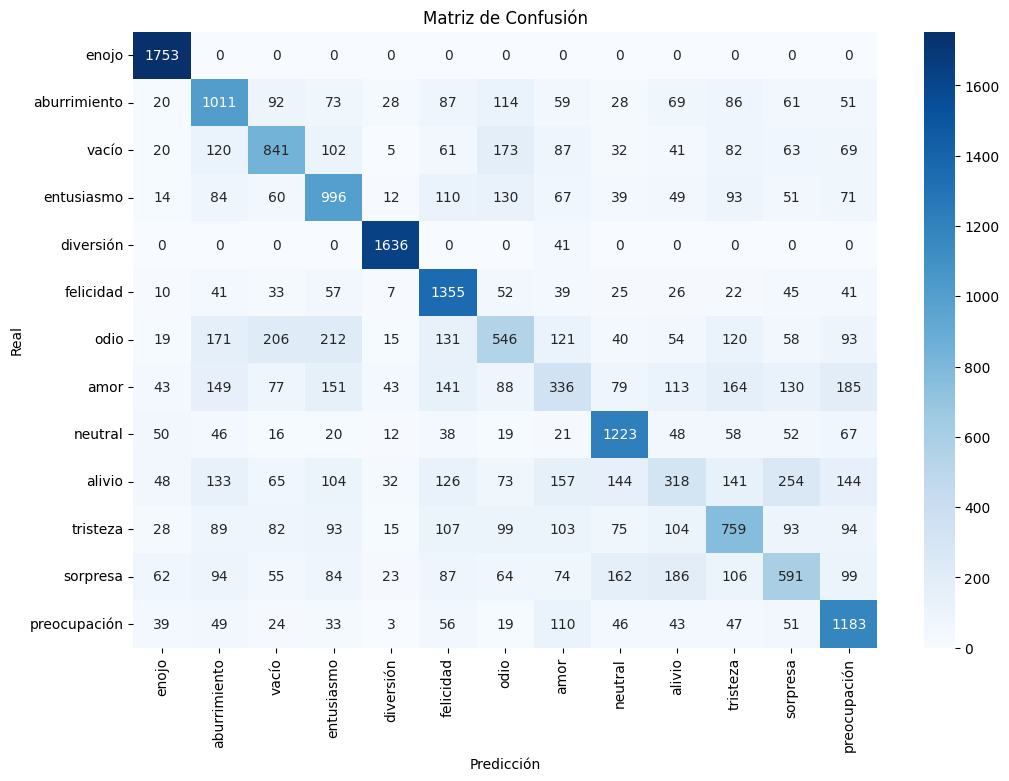

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

# Montar Google Drive
drive.mount('/content/drive')

# Leer los datos
data = pd.read_csv('/content/drive/MyDrive/Proyecto colaborativo/3 - ISPC /Procesamiento del Habla/tweet_emotions.csv')
data.head()
data.info()

# Mapeo de sentimientos a español
sentimientos_esp = {
    'anger': 'enojo',
    'boredom': 'aburrimiento',
    'empty': 'vacío',
    'enthusiasm': 'entusiasmo',
    'fun': 'diversión',
    'happiness': 'felicidad',
    'hate': 'odio',
    'love': 'amor',
    'neutral': 'neutral',
    'relief': 'alivio',
    'sadness': 'tristeza',
    'surprise': 'sorpresa',
    'worry': 'preocupación'
}
data['sentiment'] = data['sentiment'].map(sentimientos_esp)

# Preprocesamiento de texto
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@[\w_]+', '', text)  # Eliminar menciones de usuarios
    text = re.sub(r'\#', '', text)  # Eliminar hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_content'] = data['content'].apply(preprocess_text)

# Vectorización y balanceo de datos
X = data['processed_content']
y = data['sentiment']
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)
ros = RandomOverSampler(random_state=42)
X_tfidf_resampled, y_resampled = ros.fit_resample(X_tfidf, y)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenamiento del modelo
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(report)

# Matriz de Confusión
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sentimientos_esp.values(), yticklabels=sentimientos_esp.values())
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()
